# MS002 Epoching
06/26/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re
import scipy

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS002'
subj_format = ['nlx']
subj_site = ['MSSM']


### Import Preprocessed Data

In [5]:
mne_data_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', preload=True)

photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

In [6]:
mne_data_reref

<Raw | wm_ref_ieeg.fif, 125 x 1109504 (2167.0 s), ~1.03 GB, data loaded>

In [7]:
photodiode_data

<Raw | photodiode.fif, 1 x 1109504 (2167.0 s), ~8.5 MB, data loaded>

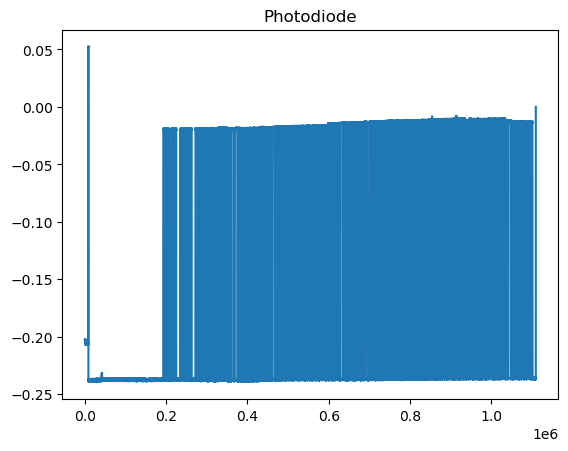

In [8]:
# Sanity check the photodiode
plt.plot(photodiode_data._data[0,])
plt.title("Photodiode")
plt.show()

### Load Anat Recon Info 


In [9]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,NMMlabel,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,Manual Examination,Notes
0,LaCaS1,A32sg_L,-6.784557,49.555827,0.149337,-6.382462,37.158688,-3.130044,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus D,NaN,NaN
1,LaCaS10,A9l_L,-8.380923,61.155821,43.676991,-8.220073,48.757099,44.868611,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Medial Gyrus,L SFG,Left superior frontal gyrus 2 C,NaN,NaN
2,LaCaS11,A9l_L,-8.780014,62.355821,48.469026,-8.542609,49.887710,50.203768,Unknown,Left SFG superior frontal gyrus,Unknown,L Superior Medial Gyrus,L SFG,Left superior frontal gyrus 2 C,OOB,NaN
3,LaCaS12,Unknown,-8.780014,63.555820,53.261062,-8.436667,51.044299,55.539730,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
4,LaCaS2,A32sg_L,-6.784557,50.755827,4.941372,-6.368174,38.606223,2.270621,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus E,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,RmOIF5,A12/47o_R,33.922762,42.355831,-8.636061,34.666463,28.882016,-13.444118,White,Right Cerebral White Matter,Unknown,R IFG (p Orbitalis),R OrG,Right frontal orbital 4 D,WM,NaN
154,RmOIF6,A12/47l_R,37.913675,41.555831,-6.240044,38.716568,28.139395,-11.063832,Gray,Right Cerebral White Matter,Unknown,R IFG (p Orbitalis),R OrG,Right frontal orbital 4 D,NaN,NaN
155,RmOIF7,A12/47l_R,41.904589,40.755832,-3.844026,42.794042,27.279509,-8.584441,Gray,Right OrIFG orbital part of the inferior front...,Unknown,R IFG (p Orbitalis),R OrG,Right pars orbitalis C,NaN,NaN
156,RmOIF8,A12/47l_R,46.294594,39.555832,-1.048672,47.308597,25.926043,-5.816665,Gray,Right OrIFG orbital part of the inferior front...,Unknown,R IFG (p Orbitalis),R OrG,Right middle pars triangularis B,NaN,NaN


## Load behavior

In [10]:
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,util_g,util_s,p_g,p_s
0,1,25.0,mix,513.380590,513.390239,515.450091,515.457173,2.059852,0.0,-1.10,...,-0.57,-0.57,-0.57,-0.57,0.00,0.00,-1.402804,0.000000,0.104940,0.895060
1,2,117.0,loss,522.640856,522.641563,524.596127,526.627092,1.954564,-0.3,-0.95,...,-0.95,-0.65,-0.95,-0.65,0.00,0.00,-1.524196,-1.186987,0.373961,0.626039
2,3,79.0,gain,531.174799,531.175599,532.759061,534.780269,1.583462,0.4,0.00,...,0.00,1.28,0.00,0.00,1.68,1.28,0.764421,0.472476,0.609711,0.390289
3,4,42.0,mix,545.592613,545.593355,548.084966,548.092333,2.491611,0.0,-0.80,...,-1.20,-1.20,0.00,0.00,0.80,0.80,-0.743808,0.000000,0.242954,0.757046
4,5,85.0,gain,555.337336,555.345720,557.114656,559.135069,1.768936,0.5,0.00,...,0.00,0.74,0.00,0.00,1.24,0.74,0.596230,0.567124,0.511117,0.488883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,135.0,loss,2082.720686,2082.729062,2087.254288,2089.276627,4.525226,-0.5,-1.24,...,0.00,0.50,0.00,0.00,1.24,0.50,-1.895450,-1.802922,0.464712,0.535288
146,147,4.0,mix,2094.678701,2094.679411,2096.700082,2096.707465,2.020671,0.0,-0.30,...,-0.16,-0.16,-0.16,-0.16,0.00,0.00,-0.481877,0.000000,0.323810,0.676190
147,148,136.0,loss,2107.766044,2107.770228,2110.494307,2112.504396,2.724080,-0.5,-1.40,...,-1.40,-0.90,-1.40,-0.90,0.00,0.00,-2.093342,-1.802922,0.390844,0.609156
148,149,66.0,gain,2117.339199,2117.344685,2118.940681,2120.950084,1.595996,0.3,0.00,...,-0.84,-0.30,-0.84,-0.30,0.00,0.00,0.433521,0.373377,0.522959,0.477041


In [11]:
beh_ts = behav_df['TrialOnset']

## Photodiode alignment

In [16]:
# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, 
                                            smoothSize=11, windSize=15, height=0.8)

10 blocks
..........

found matches for 120 of 163 pulses


## Make epochs

In [20]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}


In [22]:

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0],
       'DecisionOnset': [0, 3.0]}

In [23]:
epochs_all_evs = {f'{x}': np.nan for x in evs}
epochs_all_baseline = {f'{x}': np.nan for x in evs}

In [24]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', 
                 elec_path=anat_file, 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, 
                 downsamp_factor=2, IED_args=IED_args)

    epochs_all_evs[event] = ev_epochs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 334 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 17618 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 18750 out of 18750 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 18290 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 18750 out of 18750 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend w

In [26]:
epochs_all_evs

{'TrialOnset': <Epochs |  150 events (all good), -2 - 0.996094 sec, baseline off, ~110.0 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 3.99609 sec, baseline off, ~183.3 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add metadata to epochs

In [27]:
for event in evs.keys():

    # Let's add our behavioral events to the metadata. Substitute this with the particulars for your behavioral dataframe. 

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    event_metadata['safe'] = behav_df['SafeBet'].tolist()
    event_metadata['low'] = behav_df['LowBet'].tolist()
    event_metadata['high'] = behav_df['HighBet'].tolist()
    event_metadata['profit'] = behav_df['Profit'].tolist()
    event_metadata['outcome'] = behav_df['Outcome'].tolist()
    #model-free vars
    event_metadata['g_ev'] = behav_df['GambleEV'].tolist()
    event_metadata['cr'] = behav_df['CR'].tolist()
    event_metadata['c_ev'] = behav_df['choiceEV'].tolist()
    event_metadata['rpe'] = behav_df['RPE'].tolist()
    event_metadata['tcpe'] = behav_df['totalCPE'].tolist()
    event_metadata['dcpe'] = behav_df['decisionCPE'].tolist()
    event_metadata['tregret'] = behav_df['totalRegret'].tolist()
    event_metadata['dregret'] = behav_df['decisionRegret'].tolist()
    event_metadata['trelief'] = behav_df['totalRelief'].tolist()
    event_metadata['drelief'] = behav_df['decisionRelief'].tolist()
    event_metadata['util_g'] = behav_df['util_g'].tolist()
    event_metadata['util_s'] = behav_df['util_s'].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

In [28]:
epochs_all_evs[event].metadata

,lloif10,lmoif4,lmoif14,rmoif5,rmoif11,rmoif12,lacas9,lacas11,lacas12,racas10,...,c_ev,rpe,tcpe,dcpe,tregret,dregret,trelief,drelief,util_g,util_s
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.57,-0.57,-0.57,-0.57,0.00,0.00,-1.402804,0.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.475,-0.475,-0.95,-0.65,-0.95,-0.65,0.00,0.00,-1.524196,-1.186987
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.840,0.840,0.00,1.28,0.00,0.00,1.68,1.28,0.764421,0.472476
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-1.20,-1.20,0.00,0.00,0.80,0.80,-0.743808,0.000000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.620,0.620,0.00,0.74,0.00,0.00,1.24,0.74,0.596230,0.567124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.620,0.620,0.00,0.50,0.00,0.00,1.24,0.50,-1.895450,-1.802922
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.16,-0.16,-0.16,-0.16,0.00,0.00,-0.481877,0.000000
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.700,-0.700,-1.40,-0.90,-1.40,-0.90,0.00,0.00,-2.093342,-1.802922
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.420,-0.420,-0.84,-0.30,-0.84,-0.30,0.00,0.00,0.433521,0.373377


### Save epoched data

In [29]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/epoch_{event}.fif', overwrite=True)